### 1.没有明显报错的正常的log输出

首先导入一些用到的库

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)

先来看看数据长什么样子

In [2]:
mnist = input_data.read_data_sets("./")

print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

print(mnist.test.images.shape)
print(mnist.test.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000,)
(5000, 784)
(5000,)
(10000, 784)
(10000,)


可以看到images里面有数量不等的图片，每张图片是28x28长度的一个一维向量， 所以用的时候需要先给它还原成28x28的二维图片。labels中则是图片对应的数字的值。

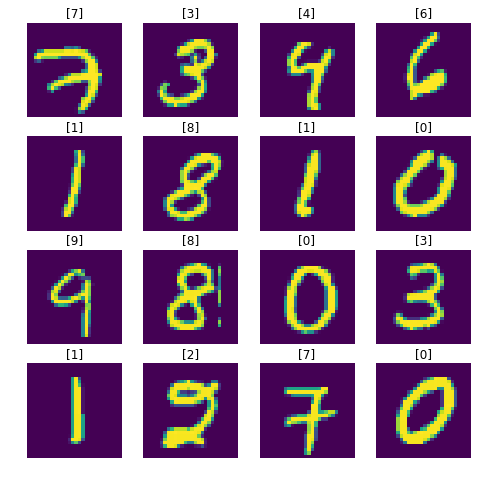

In [3]:
plt.figure(figsize=(8,8))

for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.axis('off')
    plt.title('[{}]'.format(mnist.train.labels[idx]))
    plt.imshow(mnist.train.images[idx].reshape((28,28)))

接下来，定义用于训练的网络，首先定义网络的输入。

这里我们直接使用上面的数据作为输入，所以定义两个placeholder分别用于图像和lable数据，另外，定义一个float类型的变量用于设置学习率。

为了让网络更高效的运行，多个数据会被组织成一个batch送入网络，两个placeholder的第一个维度就是batchsize，因为我们这里还没有确定batchsize，所以第一个维度留空。

In [4]:
x = tf.placeholder("float", [None, 784])
y = tf.placeholder("int64", [None])
learning_rate = tf.placeholder("float")

In [5]:
def initialize(shape, stddev=0.1):
  return tf.truncated_normal(shape, stddev=0.1)

L1_units_count = 100

W_1 = tf.Variable(initialize([784, L1_units_count]))
b_1 = tf.Variable(initialize([L1_units_count]))
logits_1 = tf.matmul(x, W_1) + b_1
output_1 = tf.nn.relu(logits_1)

L2_units_count = 10 
W_2 = tf.Variable(initialize([L1_units_count, L2_units_count]))
b_2 = tf.Variable(initialize([L2_units_count]))
logits_2 = tf.matmul(output_1, W_2) + b_2  

logits = logits_2

Instructions for updating:
Colocations handled automatically by placer.


接下来定义loss和用于优化网络的优化器。loss计算使用了sparse_softmax_cross_entropy_with_logits, 这样做的好处是labels可以不用手动做one_hot省了一些麻烦。这里使用了sgd优化器，学习率为可以根据需要设定。

试试看，增大减小学习率，换个优化器再进行训练会发生什么。

In [6]:
cross_entropy_loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(cross_entropy_loss)

需要注意的是，上面的网络，最后输出的是未经softmax的原始logits，而不是概率分布， 要想看到概率分布，还需要做一下softmax。

将输出的结果与正确结果进行对比，即可得到我们的网络输出结果的准确率。

In [7]:
pred = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(pred, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

saver用于保存或恢复训练的模型。

In [8]:
batch_size = 32
trainig_step = 1000

saver = tf.train.Saver()

以上定义的所有操作，均为计算图，也就是仅仅是定义了网络的结构，实际需要运行的话，还需要创建一个session，并将数据填入网络中。

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    #定义验证集与测试集
    validate_data = {
        x: mnist.validation.images,
        y: mnist.validation.labels,
    }
    test_data = {x: mnist.test.images, y: mnist.test.labels}

    for i in range(trainig_step):
        xs, ys = mnist.train.next_batch(batch_size)
        _, loss = sess.run(
            [optimizer, cross_entropy_loss],
            feed_dict={
                x: xs,
                y: ys,
                learning_rate: 0.3
            })

        #每100次训练打印一次损失值与验证准确率
        if i > 0 and i % 100 == 0:
            validate_accuracy = sess.run(accuracy, feed_dict=validate_data)
            print(
                "after %d training steps, the loss is %g, the validation accuracy is %g"
                % (i, loss, validate_accuracy))
            saver.save(sess, './model.ckpt', global_step=i)

    print("the training is finish!")
    #最终的测试准确率
    acc = sess.run(accuracy, feed_dict=test_data)
    print("the test accuarcy is:", acc)

after 100 training steps, the loss is 1.07468, the validation accuracy is 0.8522
after 200 training steps, the loss is 0.375225, the validation accuracy is 0.9192
after 300 training steps, the loss is 0.396863, the validation accuracy is 0.9256
after 400 training steps, the loss is 0.0697651, the validation accuracy is 0.9342
after 500 training steps, the loss is 0.304579, the validation accuracy is 0.9362
after 600 training steps, the loss is 0.135362, the validation accuracy is 0.9436
Instructions for updating:
Use standard file APIs to delete files with this prefix.
after 700 training steps, the loss is 0.534445, the validation accuracy is 0.944
after 800 training steps, the loss is 0.199088, the validation accuracy is 0.953
after 900 training steps, the loss is 0.306011, the validation accuracy is 0.9508
the training is finish!
the test accuarcy is: 0.9453


下面，用我们训练的模型做一个测试。

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt-900
0.9375


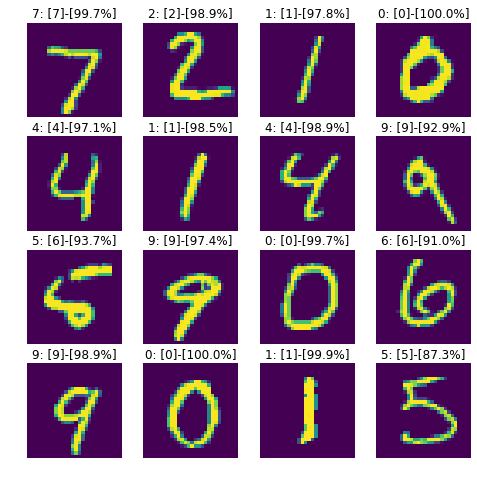

In [10]:
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('./')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        final_pred, acc = sess.run(
            [pred, accuracy],
            feed_dict={
                x: mnist.test.images[:16],
                y: mnist.test.labels[:16]
            })
        orders = np.argsort(final_pred)
        plt.figure(figsize=(8, 8))
        print(acc)
        for idx in range(16):
            order = orders[idx, :][-1]
            prob = final_pred[idx, :][order]
            plt.subplot(4, 4, idx + 1)
            plt.axis('off')
            plt.title('{}: [{}]-[{:.1f}%]'.format(mnist.test.labels[idx],
                                                  order, prob * 100))
            plt.imshow(mnist.test.images[idx].reshape((28, 28)))

    else:
        pass

以作业提供的参数运行出来的结果，只看上面几个数字还是很不错的，但是总体准确率不太理想。

### 2.对模型结构的理解

这个数字识别用的是单层的多神经元的模型。

### 3.对模型训练过程（梯度如何计算，参数如何更新）的理解

利用train_step = tf.train.GradientDescentOptimizer().minimize()，模型训练的时候运行train_step这个操作，每运行一次神经网络就会将输入前向和反向各运行一次，损失函数利用梯度下降的权重优化方式优化，然后更新参数。

### 4.对计算图的理解

tensorflow是一个符号计算的框架，所以在tensorflow里写下加减乘除这样一些操作的时候，实际上对应的是一个计算的图（Graph），而不是一个计算动作，生成的计算图由节点（Node）构成。实际的计算动作需要新建一个Session，用它把Graph里面的运算都运行一遍，这时候Graph才会被运行起来有运行结果。

### 5.解释这⾥的模型为什么效果⽐较差

这里的模型学习率设置的比较大，而且训练次数不够大，可以适当增加训练次数，分批次调整学习率。